In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
import csv

data = open('../data/data.csv', 'r').readlines()
fieldnames = ['x', 'y', 'z', 'unmasked', 'synapses']
reader = csv.reader(data)
reader.next()

rows = [[int(col) for col in row] for row in reader]

sorted_x = sorted(list(set([r[0] for r in rows])))
sorted_y = sorted(list(set([r[1] for r in rows])))
sorted_z = sorted(list(set([r[2] for r in rows])))

vol = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    vol[sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = r[-1]

Great — we're done with setup. 

# Analysis — Week 2


## 1. Layers of Cortex
Let's look closer at the layers of cortex and determine their boundaries statistically.

In [4]:
y_sum = [0] * len(vol[0,:,0])
for i in range(len(vol[0,:,0])):
    y_sum[i] = sum(sum(vol[:,i,:]))

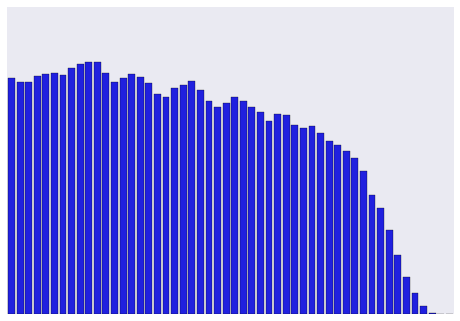

In [5]:
ax = sns.barplot(x=range(len(y_sum)), y=y_sum, color="b")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

Above, we see a histogram of `y_sum` that indicates that there is a local minimum at the 12th layer of y-sampling, which colocates with where we anticipate seeing the boundary between layers I and II. Here is the biological substantiation:

![image](https://cloud.githubusercontent.com/assets/693511/14183355/e9eafbd6-f73d-11e5-9769-8ce69e30774b.png)

As we can see, at about 1/3 of the 'depth' into cortex is the boundary to layer II.

# 2. Generate local minima by subsection of cortex
We'll use these local minima to decide where to draw the lines between layers of cortex on the imagery.

In [6]:
from scipy.signal import argrelextrema
def local_minima(a):
    return argrelextrema(a, np.less)

whole_volume_minima = local_minima(np.array(y_sum))

In [7]:
whole_volume_minima

(array([ 2,  6, 12, 18, 24, 30, 34]),)

Now let's examine smaller chunks of the volume:

In [8]:
CHUNK_SIZE = 25
sections = [(i*CHUNK_SIZE, (i+1)*CHUNK_SIZE) for i in range(len(vol[:,0,0]) / CHUNK_SIZE)]

histogram = {}

for s in sections:
    section = vol[s[0]:s[1]]
    
    histogram[s] = [0] * len(vol[0,:,0])
    for i in range(len(vol[0,:,0])):
        histogram[s][i] = sum(sum(vol[s[0]:s[1],i,:]))

In [9]:
h_local_minima = []
for t, h in histogram.iteritems():
    h_local_minima.extend([i for i in local_minima(np.array(h))])

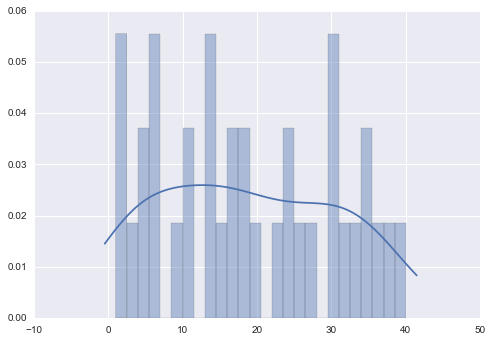

In [10]:
total_histogram = [item for sublist in h_local_minima for item in sublist]
sns.distplot(total_histogram, bins=26)

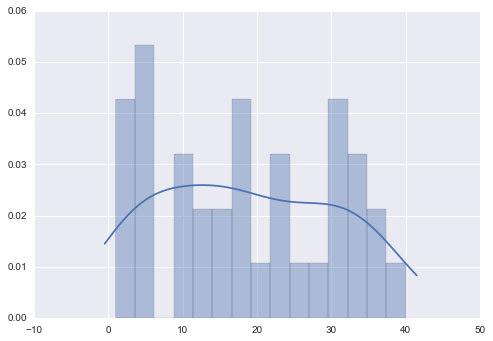

In [11]:
sns.distplot(total_histogram, bins=15)

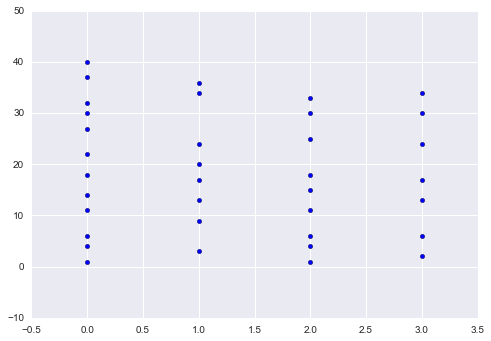

In [12]:
scatterable = []
i = 0
for h in h_local_minima:
    [scatterable.append([i, m]) for m in h]
    i += 1

plt.scatter(x=[s[0] for s in scatterable], y=[s[1] for s in scatterable])

This coincides with our understanding that our sample space extends midway into layer 4, but covers all of layers 1, 2, and 3. 

> To play with these parameters, try changing `CHUNK_SIZE` to other values to change how small the sections of subcortex are.

## 3. Clustering and Selecting "Real" Cortex Boundaries
We'll flatten this list in 2D and then pick centers of mass for each local-minima cluster.

In [13]:
from sklearn.cluster import KMeans

plt.scatter([0] * len(total_histogram), total_histogram)

ImportError: No module named sklearn.cluster

In [ ]:
NUM_CLUSTERS = 4

k3cluster = KMeans(n_clusters=NUM_CLUSTERS)
total_histogram.sort()
clusters_for_th = k3cluster.fit_predict(np.array(total_histogram).reshape(-1, 1))

Now we can get the centroids from these clusters. I wish I understood what I was doing.

In [ ]:
clusters = { n: [] for n in range(NUM_CLUSTERS) }

for i in range(len(total_histogram)):
    clusters[clusters_for_th[i]].append(total_histogram[i]) 

In [ ]:
clusters

Now we can assume that the means of these clusters are the actual boundaries between cortex.

In [ ]:
cluster_means = [np.mean(v) for _, v in clusters.iteritems() ]

In [ ]:
cluster_means

## 4. Verifying our statistical boundaries against an image
We know that our data are taken from `bock11` on `ndstore`, so... Now let's overlay those averages over our image.

In [ ]:
from PIL import Image
import urllib, cStringIO

file = cStringIO.StringIO(urllib.urlopen("http://openconnecto.me/ocp/ca/bock11/image/xy/7/350,850/50,936/2917/").read())
img = Image.open(file)
img_array = np.array(img)

In [ ]:
cluster_means = np.array(cluster_means)
cluster_means_mapped = (cluster_means / vol.shape[1]) * img_array.shape[0]
for i in cluster_means_mapped:
    img_array[[i, i+10, i-10], :] -= 50

In [ ]:
Image.fromarray(img_array)

## 5. Finding Descending Processes in Cortex
We should be able to find collections of high synaptic density in regions where processes exist. We can use a simple variant of a k-means algorithm to find these clusters.

To do this, we'll first flatten along the y-plane to find descending processes.

In [ ]:
yflat = np.amax(vol, axis=1)
frame_y = pd.DataFrame(yflat)
sns.heatmap(frame_y)

In [ ]:
processkmeans = KMeans()
print yflat
processkmeans.fit_predict(yflat)

## Next steps
I want to run this cluster-finding algorithm in 3D next to see if we can isolate horizontal processes as well.